In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import geopandas

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

## Figure 2a - causal discovery

In [ ]:
## Figure 2a

def run_pcmci(dataframe, cond_ind_test, link_assumptions):
    
    pcmci = PCMCI(dataframe = dataframe, cond_ind_test = cond_ind_test)
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=1, pc_alpha=0.01, link_assumptions = link_assumptions)
    
    return results

link_assumptions = {j:{(i, -tau):'o?o' for i in range(5) for tau in range(1) if (i, -tau) != (j, 0)} for j in range(5)}
link_assumptions[0] = {(i, -tau):'o?o' if i == 1 else '-?>' for i in [3,4] for tau in range(1) if (i, -tau) != (0, 0)}
link_assumptions[1] = {(i, -tau):'o?o' if i == 0 else '-?>' for i in [2,3] for tau in range(1) if (i, -tau) != (1, 0)}
link_assumptions[2] = {(i, -tau):'<?-' if i in [1] else '-?>' for i in [1,2,3,4] for tau in range(1) if (i, -tau) != (2, 0)}
link_assumptions[3] = {(i, -tau):'<?-' if i in [0,1,2] else '-?>' for i in range(5) for tau in range(1) if (i, -tau) != (3, 0)}
link_assumptions[4] = {(i, -tau):'<?-' if i in [0,1,2,3] else '-?>' for i in [0,2,3,4] for tau in range(1) if (i, -tau) != (4, 0)}


link_assumptions[1][(0, 0)] = '-?>' 
link_assumptions[0][(0, -1)] = 'o?o'
link_assumptions[1][(1, -1)] = 'o?o'
link_assumptions[0][(1, -1)] = '<?-'
link_assumptions[2][(2, -1)] = 'o?o'
link_assumptions[3][(3, -1)] = 'o?o'
link_assumptions[4][(4, -1)] = 'o?o'

dataStacked = np.load('/data/stacked-01-21-std.npy', allow_pickle = True)

dims = dataStacked.shape

dS = np.array([dataStacked[i,:,:] for i in range(5)])
d = {i: dS[:,i,:].transpose() for i in range(dims[1])}
dataframe = pp.DataFrame(d, analysis_mode = 'multiple', var_names = ['tmin','tmax','sw','cloudiness','aod'])
results1 = run_pcmci(dataframe, ParCorr(),link_assumptions)

tp.plot_graph(graph=results1['graph'], val_matrix=results1['val_matrix'], save_name = 'figure2a.png',
               var_names=[r'T$_{\text{min}}$',r'T$_{\text{max}}$','SW','Clouds','AOD'], node_pos = {'x':[0,1,3,4,2],'y':[2,0,0,2,4]},
               node_aspect = 0.8, node_size = 0.8, label_fontsize = 12, link_label_fontsize = 12, tick_label_size = 10)

## Figure 2b - causal effects

In [34]:
had = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/data/causal-effects-HadGEM3-01-14/*.npy')]

had = pd.DataFrame()
had['id'] = np.arange(len(latlon))

had['lat'] = np.nan
had['lon'] = np.nan

had.columns = had.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(had.id == i)[0][0]
    had.loc[k,'lat'] = latlon[i][0]
    had.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-HadGEM3-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                had.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                had.loc[k, cols[n]] = result[n][0]*100
            else:
                had.loc[k, cols[n]] = result[n][0]

In [35]:
can = pd.DataFrame()

latlon = [[i.split('/')[-1].split('-')[0],i.split('/')[-1].split('-')[1][:-4]] if len(i.split('/')[-1].split('-')) == 2 else [i.split('/')[-1].split('-')[0],'-'+i.split('/')[-1].split('-')[-1][:-4]] for i in glob.glob('/data/causal-effects-CanESM5-01-14/*.npy')]

can = pd.DataFrame()
can['id'] = np.arange(len(latlon))

can['lat'] = np.nan
can['lon'] = np.nan

can.columns = can.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(can.id == i)[0][0]
    can.loc[k,'lat'] = latlon[i][0]
    can.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-CanESM5-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                can.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                can.loc[k, cols[n]] = result[n][0]*100
            else:
                can.loc[k, cols[n]] = result[n][0]

In [36]:
obs = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/data/causal-effects-v27-01-14/*.npy')]

obs = pd.DataFrame()
obs['id'] = np.arange(len(latlon))

obs['lat'] = np.nan
obs['lon'] = np.nan

obs.columns = obs.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(obs.id == i)[0][0]
    obs.loc[k,'lat'] = latlon[i][0]
    obs.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-v27-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['','[W/m2]','[K]','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            if n == 0:
                obs.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                obs.loc[k, cols[n]] = result[n][0]*100
            else:
                obs.loc[k, cols[n]] = result[n][0]

In [1]:
import matplotlib.pyplot as plt



colors = ['black','tab:purple','tab:green']
legend = ['Obs','HadGEM3-GC31-LL','CanESM5']

ptx = [0,0,0,0,0,0,0,1,1,1,1,1,1,1]
pty = [0,1,2,3,4,5,6,0,1,2,3,4,5,6]
source = [0,1,2]
src = [obs, had, can]
# columns = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax']
columns = ['AOD-CC','CC-SW','SW-Tmax','CC-Tmax','AOD-SW','CC-Tmin','AOD-Tmin','Tmax-Tmin','Tmin-Tmax']
title = ['AOD-CC','AOD-SW [W]','AOD-Tmin [K]','CC-SW [W]','CC-Tmax [K]','CC-Tmin [K]',r'SW-Tmax [$10^{-2}$ K/W]','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']

steps = [[0,0.2,0.4,0.6,0.8,1,1.2],[0,-50,-100,-150,-200,-250],[0,0.01,0.02,0.03,0.04],[2,0,-2,-4,-6,-8],[0,-50,-100,-150,-200],[-2,0,2,4,6],
         [-2,0,2,4,6],[0,0.2,0.4,0.6],[0,0.3,0.6,0.9]]
xlim = [[0,1.2],[-250,0],[0,0.04],[-8,2],[-200,0],[-2,6],[-2,6],[0,0.6],[0,0.9]]

for i in range(9):
    fig, ax = plt.subplots(1,1, figsize = (17/9,3))
    fig.set_facecolor('none')
    ax.errorbar(0, obs[columns[i]].mean(), [obs[columns[i]].mean()-obs[columns[i]].quantile([0.05]), obs[columns[i]].quantile([0.95])-obs[columns[i]].mean()],label = 'Obs', 
                       color = 'black', marker = 's', markersize = 10, capsize = 6)
    ax.errorbar(1, had[columns[i]].mean(), [had[columns[i]].mean()-had[columns[i]].quantile([0.05]), had[columns[i]].quantile([0.95])-had[columns[i]].mean()],label = 'HadGEM3-GC31-LL',
                       color = 'tab:purple', marker = 's', markersize = 10, capsize = 6)
    ax.errorbar(2, can[columns[i]].mean(), [can[columns[i]].mean()-can[columns[i]].quantile([0.05]), can[columns[i]].quantile([0.95])-can[columns[i]].mean()],label = 'CanESM5',
                       color = 'tab:green', marker = 's', markersize = 10, capsize = 6)

    ax.set_xlim(-1,3)

    ax.set_xticks([0,1,2])
    ax.set_yticks(steps[i])
    ax.set_yticklabels(steps[i])
    ax.set_ylim(xlim[i])

# Remove the box around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('none')
    if i in [6,7,8]:
        ax.set_xlabel('Obs.', 'HadGEM3', 'CanESM5')
    else:
        ax.set_xlabel('')
    
    plt.savefig('..', dpi = 600)

NameError: name 'obs' is not defined

## Figure 2c - causal effect heatmaps

In [ ]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/data/causal-effects-v27-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-v27-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['','[W/m2]','[K]','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

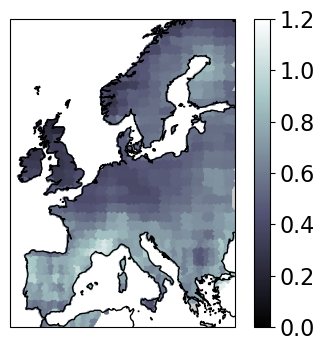

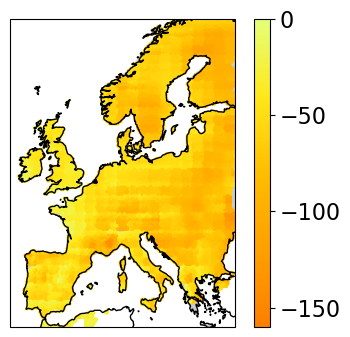

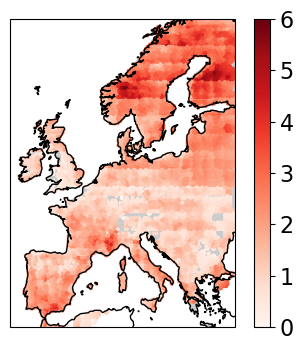

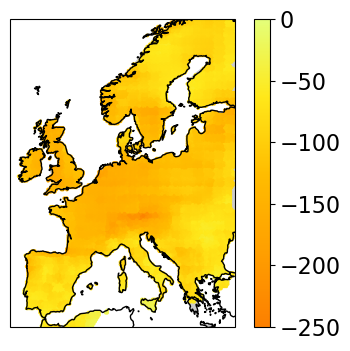

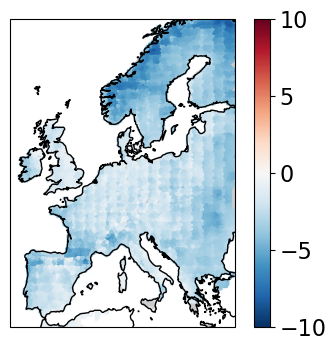

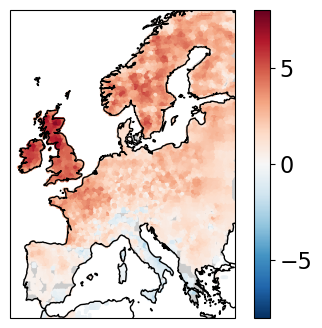

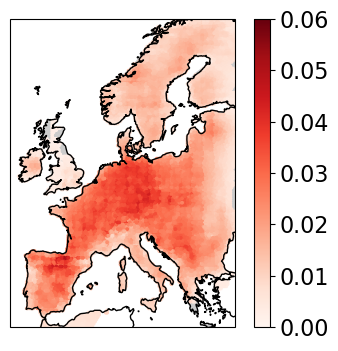

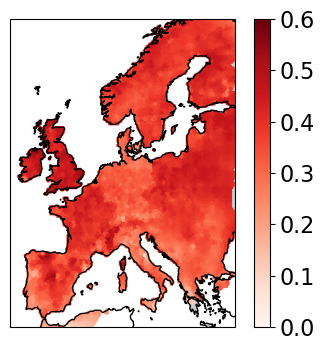

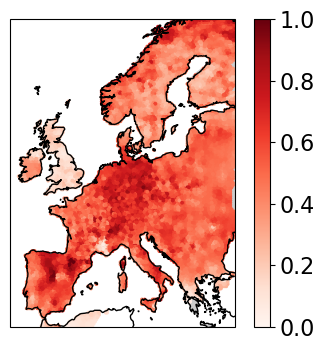

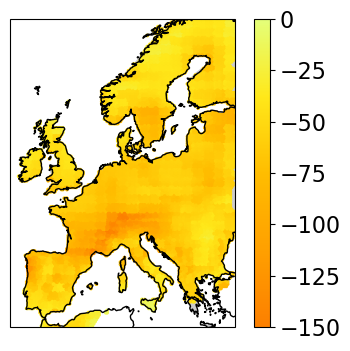

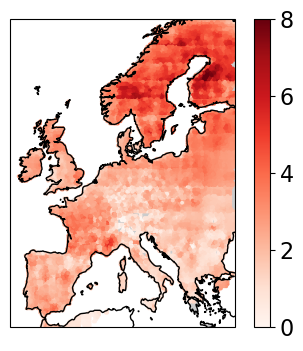

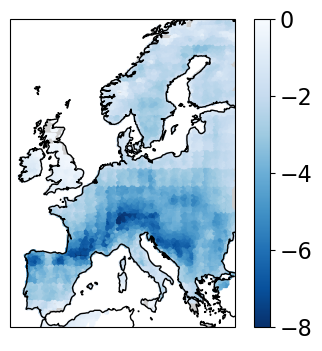

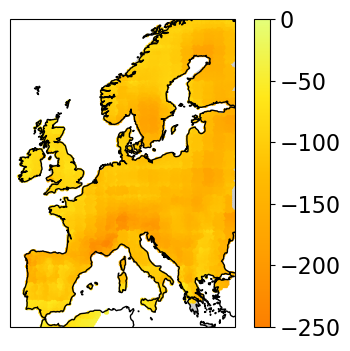

In [ ]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))


vmax = [1.2,0,6,0,10,8,0.06,0.6,1,0,8,0,0]
vmin = [0,-160,0,-250,-10,-8,0,0,0,-150,0,-8,-250]
cmap = ['bone','Wistia_r','Reds','Wistia_r','RdBu_r','RdBu_r','Reds','Reds','Reds','Wistia_r','Reds','Blues_r','Wistia_r']

cmin = [0, -160, 0, -250, -10, -8, 0, 0, 0, -150, 0, -8, -250]
cmax = [1.2, 0, 6, 0, 10, 8, 0.06, 0.6, 1, 0, 8, 0, 0]
n = [0.2, 50, 1, 50, 2, 2, 0.02, 0.1, 0.2, 25, 2, 2, 50]

for i in [1,4,9]:
    
    fig = plt.figure(figsize=(5, 4))
    ax1 = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    eu.plot(ax=ax1,alpha=0.4,color="grey")
    img = geo_df.plot(column = cols[i],ax=ax1,markersize=3, cmap = cmap[i], vmin = vmin[i], vmax = vmax[i], legend = True)#,legend_kwds = {'label':'Causal Effect ' + lab[i]})
    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=16)
    img._A = []
    ax1.set_xlim(-12,30)
    ax1.set_ylim(35,70)
    ax1.coastlines()

    plt.savefig('..', dpi = 600)